# k-NN: Curse of Dimensionality



In this notebook, we perform multi-class classification using k-Nearest Neighbors (k-NN) model on a **high-dimensional large dataset**. Our goal is to understand the problem of the curse of dimensionality that the k-NN model suffers from.  

The curse of dimensionality affects the K-NN model in four ways.
- In high-dimension, all neighbors are far away (outliers)!
- Distance calculation is expensive in high-dimension.
The number of required training data increases exponentially.
- A large number of irrelevant features in high-dimensional data.

In many practical problems the 1st problem doesn't arise as it is based on the assumption that the data is uniformly distributed (it doesn't hold true). Moreover, the data may have thousands of features, but in reality, they all "live" in a much lower-dimensional space. For example, in a handwritten digit recognition problem, each pixel is a dimension. 

In this notebook, we investigate the 2nd problem of the curse of dimensionality:
        
        Distance calculation is expensive in high-dimension.

## Tasks

We perform the following three tasks:

- Task 1: We use a high-dimensional and large dataset to show that distance calculation is expensive (time-consuming), which results in **awfully large "training" time** using a k-NN model.

- Task 2: We compare the "training time" of the k-NN model (48 minutes) with that of the Random Forest model (2+ minutes), and show that it takes about 20 times less time to train a Random Forest classifier on the same dataset.

- Task 3: Finally, to combat the curse of dimensionality in K-NN, we apply the dimensionality reduction technique and show that the K-NN "training" time can be significantly reduced (2 min 40 sec). 


## Dataset: MNIST


We use the MNIST (Modified National Institute of Standards and Technology) dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.


There are 70,000 images. Each image is **grayscale 28 x 28 pixels**, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

Thus, each image has **784 features**. 

The task is to classify a given image of a handwritten digit into one of 10 classes representing integer values from 0 to 9, inclusively.


## Hardware Specification

The experiments in this notebook are done using a Windows PC with the following specifications:

- Processor Name: Intel Core i7-4770 CPU
- Processor Speed: 3.40 Ghz
- Number of Processors: 1
- Total Number of Cores: 4
- Memory: 16 GB


In [14]:
import warnings
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.decomposition import PCA

## Load Data, Create Data Matrix (X) & Target Vector (y)

First load the data and explore the feature names, target names, etc.

We may load the data from a local folder or load it directly from cloud using Scikit-Learn.


In [2]:
# Load the data from the local folder "data"
# mnist = loadmat('data/mnist-original.mat')

# Create the data Matrix X and the target vector y
# X = mnist["data"].T.astype('float32')
# y = mnist["label"][0].astype('int64')


# Load data using Scikit-Learn
mnist = fetch_openml('mnist_784', cache=False)

X = mnist["data"].astype('float64')
y = mnist["target"].astype('int64')


print("\nNo. of Samples: ", X.shape)
print("No. of Labels: ", y.shape)


No. of Samples:  (70000, 784)
No. of Labels:  (70000,)


## Display a Random Image

To display a digit, we need to reshape an instance’s feature vector to a 28 x 28 array. 

For displaying we use Matplotlib’s imshow() function.

We see that there are white numbers on a black background, each thickly written just in the middle and they are quite low resolution (28 x 28 pixels).

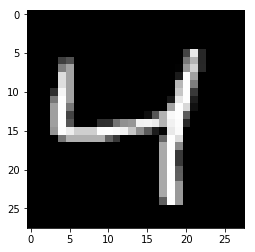

In [65]:
random_digit = X[2]

random_digit_image = random_digit.reshape(28, 28)

plt.imshow(random_digit_image, cmap = 'gray', interpolation="nearest")
#plt.axis("off")
plt.show()

## Visualize A Number With Pixel Values

Let's visualize the above number with its pixel values.

Note that the images are grayscale. Before plotting the grayscale pixel values we need to understand the grayscale image format.

### Grayscale Image Format
A grayscale (or gray level) image is simply one in which the only colors are shades of gray. The reason for differentiating such images from any other sort of color image is that less information needs to be provided for each pixel. 

In fact a 'gray' color is one in which the red, green, and blue components all have equal intensity in RGB space, and so it is only necessary to specify a single intensity value for each pixel, as opposed to the three intensities needed to specify each pixel in a full-color image.

For grayscale images, the pixel value is a single number that represents the **brightness of the pixel**. The most common pixel format is the byte image, where this number is stored as an 8-bit integer giving a range of possible values from 0 to 255. 

Typically **0 is taken to be black, and 255 is taken to be white**. Values in between make up the different shades of gray.

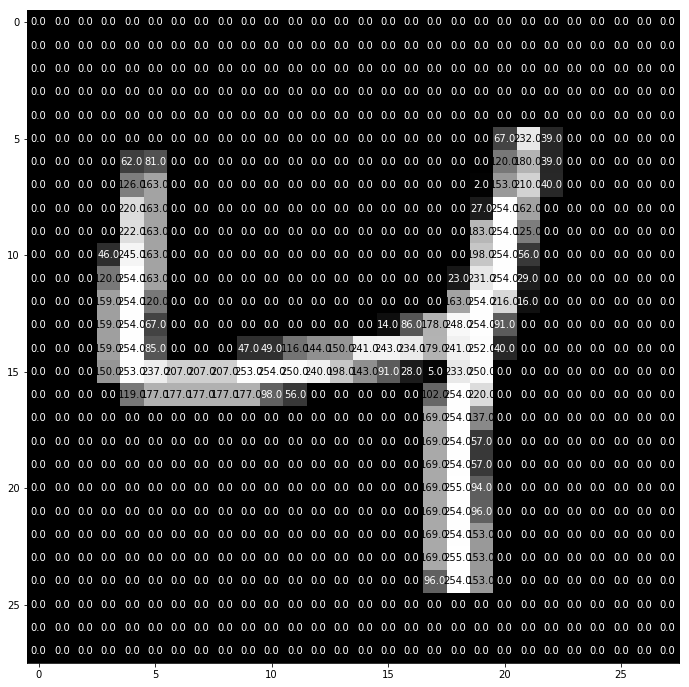

In [66]:
# Visualize a number with its pixel values
def visualize_input(img):
    fig = plt.figure(figsize = (12,12)) 
    img = img.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            plt.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

visualize_input(X[2])

## Preprocessing Data

Each image of the MNIST dataset is encoded in a 784 dimensional vector, representing a 28 x 28 pixel image. Each pixel has a value between 0 and 255, corresponding to the grey-value of a pixel.

## Data Saling

Before applying the k-NN on MNIST data, we need to scale the features. We can use the standardization technique. Another common choice of data scaling for image data is Min-Max scaling or Min-Max normalization.

$X = \frac{X - X_{min}}{X_{max} - X_{min}}$

=> $X = \frac{X - 0}{255 - 0} = \frac{X}{255}$

In [4]:
X /= 255.0

# Display the minimum and maximum values of the scaled data
X.min(), X.max()

(0.0, 1.0)

## Create Train and Test Dataset

We use sklearn's train_test_split function to spilt the dataset into training and test subsets. The data is shuffled by default before splitting.

This function splits arrays or matrices into **random** train and test subsets.

For the **reproducibility of the results**, we need to use the same seed for the random number generator. The seed is set by the "random_state" parameter of the split function. 

However, in repeated experiments if we don't want to use the same train and test subsets, then we drop the "random_state" parameter from the funtion.




In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Task 1: Demonstration of Large "Training" Time using a k-NN Model 



We use Scikit-Learn's KNeighborsClassifier for this demonstration.

## KNeighborsClassifier Parameters

We need to set the following parameters to train a KNeighborsClassifier.


- n_neighbors : int, optional (default = 5) Number of neighbors to use by default for kneighbors queries.


- weights : str or callable, optional (default = ‘uniform’) weight function used in prediction. Possible values:

    -- ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
    
    -- ‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
    
    -- [callable] : a user-defined function that accepts an array of distances, and returns an array of the same shape containing the weights.


- algorithm : {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, optional. Algorithm used to compute the nearest neighbors:

    -- ‘ball_tree’ will use BallTree
    
    -- ‘kd_tree’ will use KDTree
    
    -- ‘brute’ will use a brute-force search.
    
    -- ‘auto’ will attempt to decide the most appropriate algorithm based on the values passed to fit method.
    
    -- Note: fitting on sparse input will override the setting of this parameter, using brute force.
    

- leaf_size : int, optional (default = 30). Leaf size passed to BallTree or KDTree. This can affect the speed of the construction and query, as well as the memory required to store the tree. The optimal value depends on the nature of the problem.


- p : integer, optional (default = 2)
    
    -- Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.
    

- metric : string or callable, default ‘minkowski’. the distance metric to use for the tree. The default metric is minkowski, and with p=2 is equivalent to the standard Euclidean metric. See the documentation of the DistanceMetric class for a list of available metrics.
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html


- metric_params : dict, optional (default = None). Additional keyword arguments for the metric function.


- n_jobs : int or None, optional (default=None). The number of parallel jobs to run for neighbors search. 

    -- n_jobs= None means 1 unless in a joblib.parallel_backend context. 
   
    -- n_jobs = -1 means using all processors. 


## Model Selection: Choose a Combination of Optimal Parameters

A k-NN model is defined by a set of parameters: nearest neighbors (K), distance metric (p), etc. These are called **hyperparameters**. We need to select the best model based on the optimal values of these hyperparameters. This process is called hyperparameter tuning.

The model parameters are known as **hyperparameters** because the values of these parameters are used to control the learning process. By contrast, the values of other parameters are learned. In the k-NN model, there is no learning, thus we only tune the hyperparameters to create the optimal model

Hyperparameters are passed as arguments to the constructor of the estimator classes. We search the hyperparameter space for the best cross-validation score.


### Hyperparameter Tuning

The best way to do hyperparameter tuning is to use cross-validation.

We will use Scikit-Learn’s **GridSearchCV** to search the combinations of hyperparameter values that provide the best performance.

We need to tell which hyperparameters we want the GridSearchCV to experiment with, and what values to try out. It will evaluate all the possible combinations of hyperparameter values, using cross-validation. 

We will tune the following hyperparameters of the GridSearchCV model.

- n_neighbors 
- weights 
- p 
    


### GridSearchCV Parameters

Following are the most frequently used parameters by GridSearchCV.

- estimator : estimator object. This is assumed to implement the scikit-learn estimator interface. Either the estimator needs to provide a score function, or scoring must be passed.

- param_grid : Dictionary with parameters names (string) as keys and lists of parameter settings to try as values, or a list of such dictionaries, in which case the grids spanned by each dictionary in the list are explored. This enables searching over any sequence of parameter settings.

- scoring : string, callable, list/tuple, dict or None, default: None

    -- A single string (see The scoring parameter: defining model evaluation rules) or a callable (see Defining your scoring strategy from metric functions) to evaluate the predictions on the test set.


- n_jobs : int or None, optional (default=None). Number of jobs to run in parallel. 

    -- n_jobs= None means 1 unless in a joblib.parallel_backend context. 
   
    -- n_jobs = -1 means using all processors. 

- cv : int. Determines the cross-validation splitting strategy. None, to use the default 3-fold cross-validation.

- verbose : integer. Controls the verbosity: the higher, the more messages.


### Note: the scoring function

The GridSearchCV takes an argument to define the scoring metric (performance measure). 

See the list of possible scoring functions:
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

For multiclass classification, we may use the "f1_micro" scoring function. The f1_micro function is the average of the F1 score of each class with weighting depending on the average parameter.

In the binary classification, the f1 score function can be used. We may also use the precision, recall, and roc_auc functions.


In [6]:
%%time

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'n_neighbors': [3, 4, 5, 9], 'p': [1, 2, 1000], 'weights': ["uniform", "distance"]}


knn_clf = KNeighborsClassifier()

knn_cv = GridSearchCV(knn_clf, param_grid, scoring='f1_micro', cv=5, verbose=1, n_jobs=-1)
knn_cv.fit(X_train, y_train)


params_optimal_knn = knn_cv.best_params_

print("Best Score: %f" % knn_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn)
print("\n")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 257.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 1124.9min finished


Best Score: 0.972143
Optimal Hyperparameter Values:  {'n_neighbors': 4, 'p': 2, 'weights': 'distance'}


Wall time: 18h 45min 14s


# Observation: Time Required for Hyperparameter Tuning 

We observe that it takes about **19 hours** to perform hyperparameter tuning with only a few values for 3 hyperparameters.

## Select The Best Model 

Using the optimal hyperparameter values, create the best model.
Then, fit the model.

In [12]:
%%time

knn = KNeighborsClassifier(**params_optimal_knn)

knn.fit(X_train, y_train)

y_train_predicted = knn.predict(X_train)

train_accuracy_knn = np.mean(y_train_predicted == y_train)
print("\nTraining Accuracy: ", train_accuracy_knn)


Training Accuracy:  1.0
Wall time: 47min 19s


# Task 1 Observation: Time Required for "Training" a k-NN Model 

We observe that it takes about **48 minutes** to train a "k-NN" classifier.

Later, in task 2, we will see that using the Random Forest classifier it takes **less than 3 minutes** to train on this dataset.

## Evalute The Model Using Confusion Matrix for Training Data


We use the cross_val_predict() function to performs cross-validation, 

However, unlike cross_val_score, it doesn't return the evaluation scores.

Instead it returns the predictions made on each test fold. 

This means that we get a clean prediction for each instance in the training set.

By “clean” we mean that the prediction is made by a model that never saw the data during training).

In [13]:
%%time

y_train_pred = cross_val_predict(knn, X_train, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

Wall time: 41min 42s


array([[5549,    6,    5,    0,    0,    8,   14,    2,    1,    6],
       [   1, 6239,    8,    1,    5,    1,    3,   10,    2,    3],
       [  34,   44, 5433,   20,    5,    3,    5,   78,   16,    4],
       [   5,   12,   30, 5509,    1,   61,    2,   38,   36,   20],
       [   2,   38,    2,    1, 5290,    1,   11,    8,    2,  107],
       [  12,    5,    3,   54,    8, 4868,   47,    6,    3,   27],
       [  25,   14,    0,    0,    8,   20, 5408,    0,    4,    0],
       [   0,   61,   11,    0,    9,    1,    0, 5690,    5,   55],
       [  16,   52,   14,   71,   23,   72,   21,   17, 5092,   57],
       [  12,   12,    4,   26,   36,   12,    3,   66,    6, 5362]],
      dtype=int64)

## Evaluate The Model Using Test Data

The KNeighborsClassifier model has a default "score" function that computes the accuracy of the model.

Often times the accuracy is not a good measure.

We also create the confusion matrix for the test data.

In [15]:
%%time

# The accuracy of the model
test_accuracy_knn = knn.score(X_test, y_test)
print("\nTest Accuracy: ", test_accuracy_knn)


# No. of Correct Predictions
y_test_predicted = knn.predict(X_test)
print("\nNo. of correct predictions (Test): %d/%d" % (np.sum(y_test_predicted == y_test), len(y_test)))


# Confusion Matrix
print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_predicted))


Test Accuracy:  0.9744285714285714

No. of correct predictions (Test): 13642/14000

Confusion Matrix (Test Data):
 [[1305    0    0    0    0    0    6    1    0    0]
 [   0 1595    2    0    0    0    1    4    0    2]
 [   7    8 1311    4    0    0    1   15    0    2]
 [   0    4    9 1377    1   18    0    6    8    4]
 [   1   11    0    0 1311    0    7    3    1   28]
 [   2    0    2   14    0 1238   13    1    5    5]
 [   3    1    1    0    2    3 1386    0    1    0]
 [   1    9    5    1    4    0    0 1428    1   12]
 [   1   14    1   15    5   14    6    1 1324    9]
 [   4    3    2    9   18    2    1   10    3 1367]]
Wall time: 23min 32s


## Confusion Matrix for Test Data

Using pandas crosstab, we create a better visualization of the confusion matrix.

In [16]:
pd.crosstab(y_test, y_test_predicted, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,1305,0,0,0,0,0,6,1,0,0,1312
1,0,1595,2,0,0,0,1,4,0,2,1604
2,7,8,1311,4,0,0,1,15,0,2,1348
3,0,4,9,1377,1,18,0,6,8,4,1427
4,1,11,0,0,1311,0,7,3,1,28,1362
5,2,0,2,14,0,1238,13,1,5,5,1280
6,3,1,1,0,2,3,1386,0,1,0,1397
7,1,9,5,1,4,0,0,1428,1,12,1461
8,1,14,1,15,5,14,6,1,1324,9,1390


## Summary of Classification Metrics

We can build a text report showing the main classification metrics.

In [17]:
print(classification_report(y_test,y_test_predicted))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1312
           1       0.97      0.99      0.98      1604
           2       0.98      0.97      0.98      1348
           3       0.97      0.96      0.97      1427
           4       0.98      0.96      0.97      1362
           5       0.97      0.97      0.97      1280
           6       0.98      0.99      0.98      1397
           7       0.97      0.98      0.97      1461
           8       0.99      0.95      0.97      1390
           9       0.96      0.96      0.96      1419

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000



# Task 2: Training Time Comparison with Random Forest Classifier


We train a Random Forest classifier using the MNIST data set.

We observe the following.
- Training time is significantly faster (48 minutes for K-NN vs 2 min 15 sec for Random Forest classifier)
- The performance of the Random Forest classifier is as good as the K-NN classifier

We use optimal hyperparameters to train the Random Forest classifier.

For a detailed discussion on the Random Forest classifier, see the GitHub repository **"Decision Tree - Random Forest: Smart Tricks For Performance Enhancement"**.


In [13]:
%%time

forest_clf = RandomForestClassifier(n_estimators=1000, criterion="gini", max_features="auto", 
                                    max_depth=32, class_weight="balanced", oob_score=True, verbose=1, n_jobs=-1)

forest_clf.fit(X_train, y_train)

y_test_predicted_rf = forest_clf.predict(X_test)
print("Random Forest: Test Accuracy: ", accuracy_score(y_test, y_test_predicted_rf))

print("\nRandom Forest: Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted_rf))

print("\nRandom Forest: Classification Report:")
print(classification_report(y_test, y_test_predicted_rf))

print("\n")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.2s


Random Forest: Test Accuracy:  0.9711428571428572

Random Forest: Test Confusion Matrix:
[[1302    0    1    0    0    1    4    0    4    0]
 [   0 1581    7    3    3    2    1    4    2    1]
 [   2    3 1310    6    6    0    4    7    9    1]
 [   1    0   13 1373    0   13    0    8   12    7]
 [   2    1    1    0 1319    0    8    3    4   24]
 [   2    0    3   10    0 1238   11    2    9    5]
 [   8    2    1    0    0    6 1377    0    3    0]
 [   1    3   19    1    8    0    0 1411    2   16]
 [   1    6    8    5    6    8    3    2 1339   12]
 [   9    3    4   23   15    4    1   10    4 1346]]

Random Forest: Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1312
           1       0.99      0.99      0.99      1604
           2       0.96      0.97      0.97      1348
           3       0.97      0.96      0.96      1427
           4       0.97      0.97      0.97      1362
           5    

[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.6s finished


# Task 3: Combating the Curse Of Dimensionality in k-NN Using Dimensionality Reduction

To combat the curse of dimensionality problem with k-NN we can get rid of the irrelevant features by **projecting the features in a low-dimensional space**.

The technique for reducing the dimension of data is known as dimensionality reduction. Our assumption is that the essence or core content of the data does not span along all dimensions.

For a gentle introduction to various dimensionality reduction techniques, see the GitHub repository **"Dimensionality Reduction"**.

We use the **Principal Component Analysis (PCA)** dimensionality reduction technique to project the MNIST dataset (784 features) to a lower dimensional space by retaining maximum variance. 

The goal is to see an improvement in k-NN "training time" due to this dimensionality reduction.

Before we apply the PCA, we need to standardize the data. We have done this in the beginning of this notebook.


## Apply PCA

While applying PCA we can set the number of principal components by the "n_components" attribute. But more importantly, we can use this attribute to determine the % of variance we want to retain in the extracted features.

For example, if we set it to 0.95, sklearn will choose the **minimum number of principal components** such that 95% of the variance is retained.

In [14]:
%%time
pca = PCA(n_components=0.95)

pca.fit(X_train)

Wall time: 3.3 s


PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

## Number of Principal Components

We can find how many components PCA chose after fitting the model by using the following attribute: n_components_

We will see that 95% of the variance amounts to **154 principal components**.

In [15]:
print("Number of Principal Components: ", pca.n_components_)  

Number of Principle Components:  154


## Apply the Mapping (Transform) to both the Training Set and the Test Set

In [16]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [17]:
%%time


knn_pca = KNeighborsClassifier(n_neighbors=4, p=2, weights="distance")

knn_pca.fit(X_train_pca, y_train)


y_test_predicted_pca_knn = knn_pca.predict(X_test_pca)
print("KNN (PCA): Test Accuracy: ", accuracy_score(y_test, y_test_predicted_pca_knn))

print("\nKNN (PCA): Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted_pca_knn))

print("\nKNN (PCA): Classification Report:")
print(classification_report(y_test, y_test_predicted_pca_knn))

print("\n")

KNN (PCA): Test Accuracy:  0.9765714285714285

KNN (PCA): Test Confusion Matrix:
[[1306    0    0    0    0    0    4    2    0    0]
 [   0 1594    3    0    0    0    1    4    0    2]
 [   6    5 1320    4    0    0    0   11    0    2]
 [   1    5    8 1381    1   15    0    5    7    4]
 [   1    7    0    0 1317    0    6    3    1   27]
 [   3    0    2   11    0 1237   13    1    7    6]
 [   3    1    1    0    2    3 1386    0    1    0]
 [   1    5    5    1    2    0    0 1434    1   12]
 [   1   12    1   13    5   12    5    1 1331    9]
 [   5    3    2    9   17    2    1   11    3 1366]]

KNN (PCA): Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1312
           1       0.98      0.99      0.99      1604
           2       0.98      0.98      0.98      1348
           3       0.97      0.97      0.97      1427
           4       0.98      0.97      0.97      1362
           5       0.97     

## Task 3 Observation

We observe that after reducing the dimensionality of the dataset we are able to reduce the cost of distance calculation in k-NN, which results in significantly less "training" time.

